In [1]:
from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch

from src.utils.anchor_utils import *
from src.utils.roi_utils import *
from src.utils.training_utils import *

Test all the individual functionality required for the training pipeline

In [12]:
output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

backbone = Backbone(output_layer_map)

dog_img = Image.open("../data/dog.png")

conv3 16
conv4 23
conv5 30


In [13]:
preprocess = transforms.Compose([
    transforms.Resize((600, 600)),      
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

preprocessed_img = preprocess(dog_img).unsqueeze(0)

preprocessed_img.size()

torch.Size([1, 3, 600, 600])

In [14]:
features = backbone(preprocessed_img)

In [15]:
features.keys()

dict_keys(['conv3', 'conv4', 'conv5'])

In [16]:
print(features['conv3'].size()), print(features['conv4'].size()), print(features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 512, 37, 37])
torch.Size([1, 512, 18, 18])


(None, None, None)

In [17]:
fpn = FPN()
fpn_features = fpn(features)
print(fpn_features['conv3'].size()), print(fpn_features['conv4'].size()), print(fpn_features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 256, 37, 37])
torch.Size([1, 256, 18, 18])


(None, None, None)

In [18]:
rpn = RPN()
rpn_out = dict()
for k, v in fpn_features.items():
    rpn_out[k] = rpn(v)

In [19]:
rpn_out['conv3'][0].size(), rpn_out['conv4'][0].size(), rpn_out['conv5'][0].size(), rpn_out['conv3'][1].size(), rpn_out['conv4'][1].size(), rpn_out['conv5'][1].size()

(torch.Size([1, 18, 75, 75]),
 torch.Size([1, 18, 37, 37]),
 torch.Size([1, 18, 18, 18]),
 torch.Size([1, 36, 75, 75]),
 torch.Size([1, 36, 37, 37]),
 torch.Size([1, 36, 18, 18]))

In [21]:
img_shape = (600, 600)
feature_map_key = 'conv4'
rpn_deltas = torch.cat([rpn_out[feature_map_key][1]] * 4, dim=0)
feature_map = fpn_features[feature_map_key]
anchors = generate_anchors()

print(rpn_deltas.size(), feature_map.size(), anchors.shape)
sorted_rpn_keys = sorted(rpn_out.keys())


layer_to_shifted_anchors = dict()
for k in sorted_rpn_keys:
    print(rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))).to(rpn_out[k][1].device).float()

all_rpn_deltas = torch.cat([collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0)
print(all_rpn_deltas.size())
rois = torch.cat([generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape) for k in sorted_rpn_keys], dim=0)
scores = torch.cat([get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0)
# rois = generate_rois(rpn_deltas, anchors, img_shape)
print(rois.size(), scores.size())

rpn_gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 1]
], dtype=torch.float32)
rpn_gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 1]
], dtype=torch.float32)
gt = torch.cat([rpn_gt_batch0, rpn_gt_batch1], dim=0)

rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets, rpn_sampled_indices = matching_and_sampling(rois, scores, gt, 128)
rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]
print(rpn_sampled_proposals.size(), rpn_sampled_scores.size(), rpn_sampled_labels.size(), rpn_sampled_bbox_targets.size(), rpn_sampled_deltas.size())

unique_batches = rois[:, 0].unique()
all_proposals = []
all_scores = []

for batch_idx in unique_batches:
    batch_mask = rois[:, 0] == batch_idx
    batch_rois = rois[batch_mask]
    batch_scores = scores[batch_mask]

    # Perform NMS on the batch
    keep = nms(batch_rois, batch_scores[:, 1])
    batch_rois = batch_rois[keep]
    batch_scores = batch_scores[keep]

    _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
    sorted_proposals = batch_rois[sorted_indices]
    sorted_scores = batch_scores[sorted_indices]

    K = 2000  # for example, adjust K based on your use case
    topk_proposals = sorted_proposals[:K]
    topk_scores = sorted_scores[:K]

    all_proposals.append(topk_proposals)
    all_scores.append(topk_scores)

print(all_proposals[0].size(), all_scores[0].size())
all_proposals = torch.cat(all_proposals, dim=0)
all_scores = torch.cat(all_scores, dim=0)
print(all_proposals.size(), all_scores.size())

all_proposals = all_proposals.detach()
all_scores = all_scores.detach()

gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 2]
], dtype=torch.float32)
gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 2]
], dtype=torch.float32)
gt = torch.cat([gt_batch0, gt_batch1], dim=0)

sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, _ = matching_and_sampling(all_proposals, all_scores, gt, 128)

print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())

pooled_height, pooled_width = 3, 3

levels = sorted([int(x[-1]) for x in rpn_out.keys()])
aligned_proposals = perform_roi_align(levels, sampled_proposals, fpn_features, pooled_height, pooled_width, img_shape)

print(aligned_proposals.size())

torch.Size([4, 36, 37, 37]) torch.Size([1, 256, 37, 37]) (9, 4)
75 75 8
37 37 16
18 18 33
torch.Size([65862, 5])
torch.Size([65862, 5]) torch.Size([65862, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4]) torch.Size([128, 5])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
torch.Size([128, 256, 3, 3])


In [11]:
N, C, H, W = aligned_proposals.size()
num_classes = 4

head = DetectionHead(in_channels=C, pooled_height=H, pooled_width=W, num_classes=num_classes)

cls_scores, bbox_deltas = head(aligned_proposals)

print(cls_scores.size(), bbox_deltas.size())

torch.Size([128, 5]) torch.Size([128, 16])


In [12]:
rpn_cls_loss, rpn_bbox_loss = rpn_loss_fn(rpn_sampled_deltas, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets)
print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())
det_cls_loss, det_bbox_loss = det_loss_fn(bbox_deltas, cls_scores, sampled_labels, sampled_bbox_targets, num_classes)
print(rpn_cls_loss, rpn_bbox_loss, det_cls_loss, det_bbox_loss)

torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
tensor(0.8114, grad_fn=<NllLossBackward0>) tensor(0.4422, grad_fn=<DivBackward0>) tensor(1.5976, grad_fn=<NllLossBackward0>) tensor(0.1619, grad_fn=<DivBackward0>)


Load dataset and experiment

In [2]:
import datasets

/home/rmahajani/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = datasets.load_dataset("rishitdagli/cppe-5")

In [4]:
ds['train'][0]

{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

['Mask', 'Face_Shield', 'Coverall']


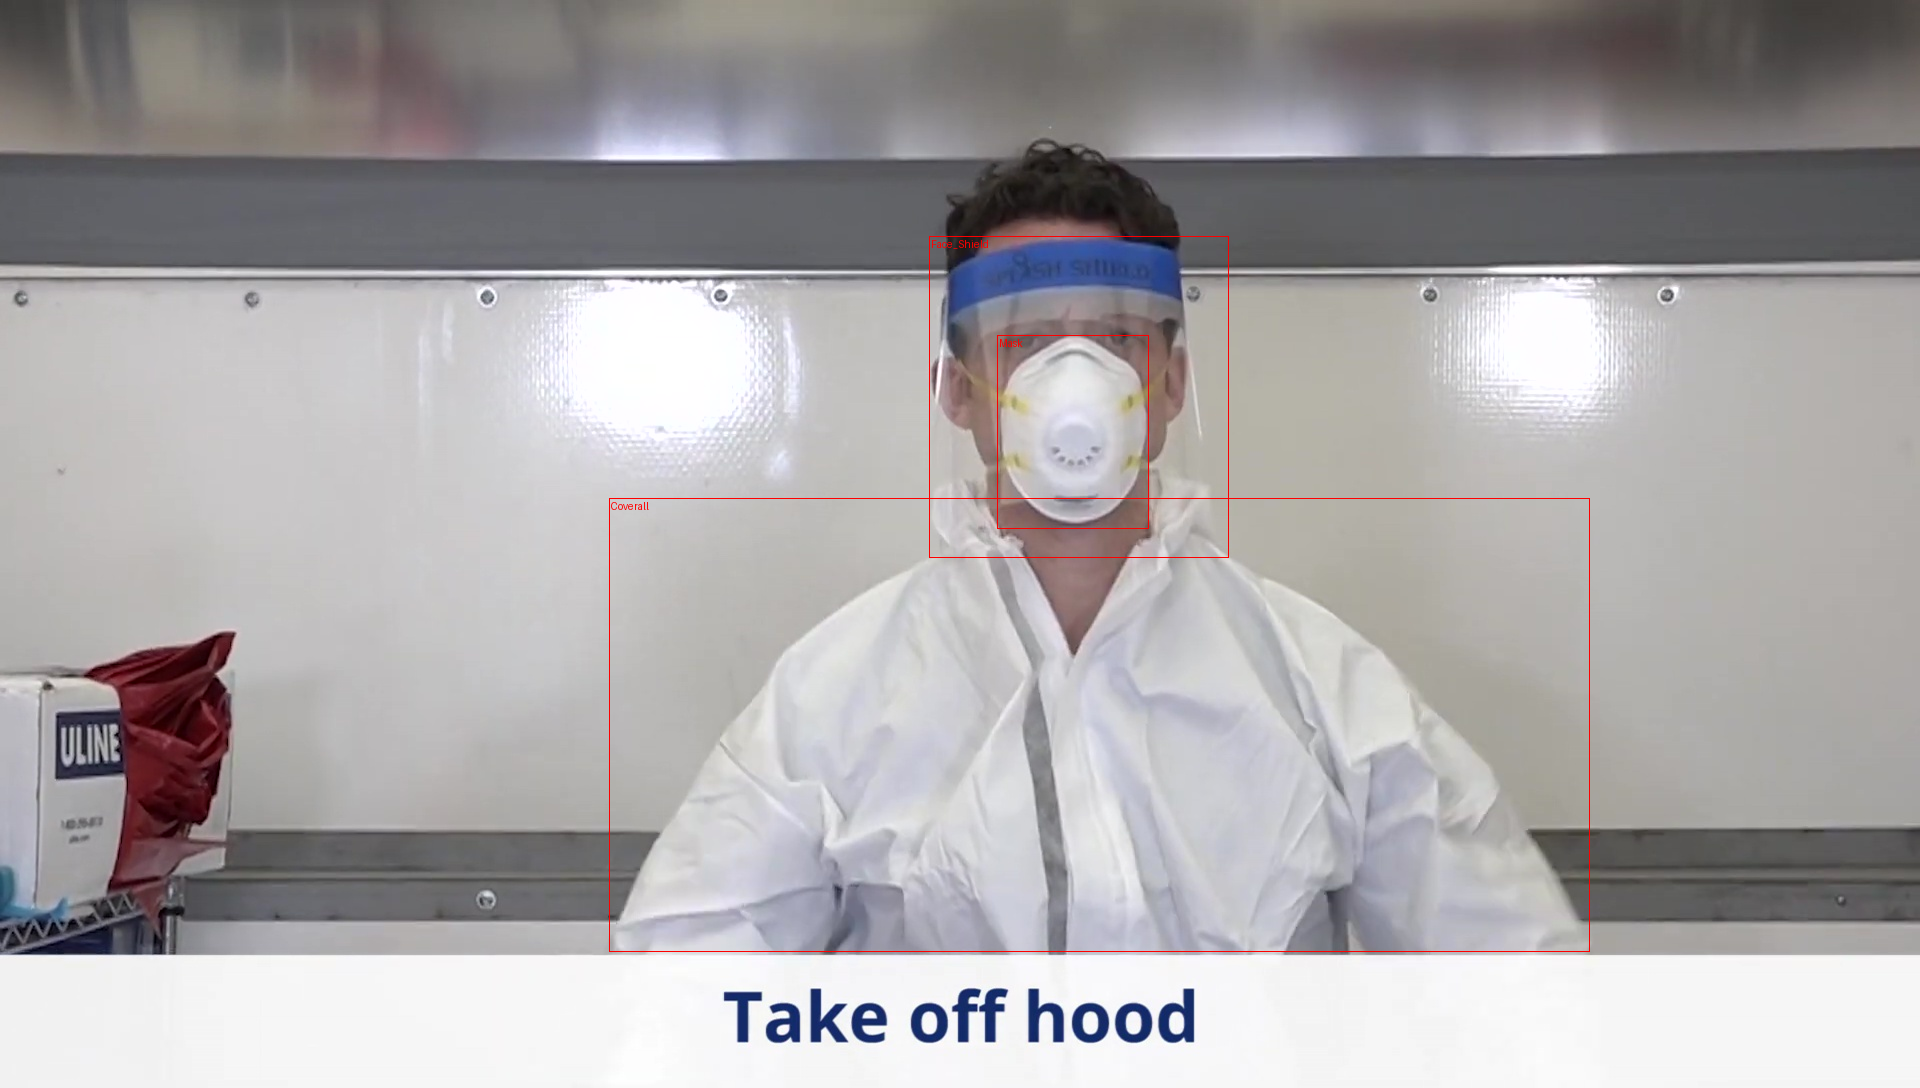

In [5]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

train_ds = ds['train']
example = train_ds[20]
categories = train_ds.features['objects'].feature['category']
boxes_xywh = torch.tensor(example['objects']['bbox'])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(x) for x in example['objects']['category']]
print(labels)
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels,
    )
)

Write training pipeline

In [6]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2

preprocess = transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

transform_pipeline = A.Compose(
    [
        A.Resize(600, 600),  # Resize image and bounding boxes to 600x600.
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(
            scale_limit=0.1, 
            rotate_limit=15, 
            shift_limit=0.1, 
            p=0.5, 
            border_mode=cv2.BORDER_CONSTANT
        )
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"])
)

class DetectionDataset(Dataset):
    def __init__(self, hf_dataset, albumentations_transform, preprocess_transform):
        """
        Args:
            hf_dataset: A Hugging Face dataset for cppe-5 object detection.
            albumentations_transform: An albumentations.Compose transform that
                applies data augmentation and expects keys "image", "bboxes", "category".
            preprocess_transform: A torchvision transform to preprocess images (e.g., for VGG16).
        """
        self.dataset = hf_dataset
        self.albumentations_transform = albumentations_transform
        self.preprocess_transform = preprocess_transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image = np.array(sample["image"])

        bboxes = sample['objects']["bbox"]  # list of bounding boxes
        labels = sample['objects']["category"]  # list of integer labels

        transformed = self.albumentations_transform(image=image, bboxes=bboxes, category=labels)

        aug_image = transformed["image"]
        aug_bboxes = transformed["bboxes"]
        aug_labels = transformed["category"]

        image_pil = Image.fromarray(aug_image)
        image_tensor = self.preprocess_transform(image_pil)

        boxes_tensor = torch.tensor(aug_bboxes, dtype=torch.float32)
        labels_tensor = torch.tensor(aug_labels, dtype=torch.int64)

        boxes_with_label = torch.cat([boxes_tensor, labels_tensor.unsqueeze(1)], dim=1)

        target = {
            "boxes": boxes_tensor,   # shape: [num_boxes, 4]
            "labels": labels_tensor,  # shape: [num_boxes]
            "boxes_with_label": boxes_with_label  # shape: [num_boxes, 5]
        }

        return image_tensor, target

def collate_fn(batch):
    print(type(batch))
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    return images, targets

/home/rmahajani/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

layer_size_map = {
    'conv3': (75, 75),
    'conv4': (37, 37),
    'conv5': (18, 18)
}

C = 256
H, W = 3, 3
num_classes = 4

backbone = Backbone(output_layer_map)
fpn = FPN()
rpn = RPN()
head = DetectionHead(in_channels=C, pooled_height=H, pooled_width=W, num_classes=num_classes)

/home/rmahajani/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rmahajani/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv3 16
conv4 23
conv5 30


In [9]:
dataset = DetectionDataset(train_ds, transform_pipeline, preprocess)
dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_shape = (600, 600)
anchors = generate_anchors()

layer_to_shifted_anchors = dict()
for k in layer_size_map.keys():
    layer_h, layer_w = layer_size_map[k]
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), layer_h, layer_w, img_shape[0] // layer_h)).to(device).float()

def matching_and_sampling(all_proposals, all_scores, gt, num_samples):
    sampled_proposals_list = []
    batch_scores_list = []
    sampled_labels_list = []
    sampled_bbox_targets_list = []
    sampled_indices_list = []

    batch_ids = all_proposals[:, 0].unique()

    pos_iou_thresh = 0.5
    neg_iou_thresh = 0.1
    pos_fraction = 0.25

    for batch_idx in batch_ids:
        batch_mask = all_proposals[:, 0] == batch_idx

        global_indices = torch.nonzero(batch_mask).squeeze(1)
        batch_proposals = all_proposals[batch_mask][:, 1:]
        batch_scores = all_scores[batch_mask]

        gt_mask = gt[:, 0] == batch_idx
        gt_b = gt[gt_mask][:, 1:5]
        gt_labels = gt[gt_mask][:, 5].long()

        N_b = batch_proposals.shape[0]
        M_b = gt_b.shape[0]

        # print(batch_proposals.size(), gt_b.size())
        
        # max_ious = torch.zeros(N_b, device=all_proposals.device)
        # gt_assignment = torch.full((N_b,), -1, dtype=torch.long, device=all_proposals.device)
        # for i in range(N_b):
        #     ious = compute_iou(batch_proposals[i], gt_b)  # shape [M_b]
        #     max_iou, idx = ious.max(0)
        #     max_ious[i] = max_iou
        #     gt_assignment[i] = idx
        print('='*10)
        print(batch_proposals.size(), gt_b.size())
        ious = compute_iou_vectorized(batch_proposals, gt_b)  # [N_b, M_b]
        print(ious.size())
        max_ious, gt_assignment = ious.max(dim=1)  # max_ious: [N_b], gt_assignment: [N_b]

        # Initialize labels for proposals (default background: label 0).
        labels_b = torch.zeros(N_b, dtype=torch.long, device=all_proposals.device)
        # Regression targets are zeros by default.
        bbox_targets_b = torch.zeros((N_b, 4), device=all_proposals.device)

        pos_inds = max_ious >= pos_iou_thresh
        if pos_inds.sum() > 0:
            labels_b[pos_inds] = gt_labels[gt_assignment[pos_inds]]
            pos_proposals = batch_proposals[pos_inds]
            matched_gt = gt_b[gt_assignment[pos_inds]]
            bbox_targets_b[pos_inds] = bbox_transform(pos_proposals, matched_gt)
        
        # print(bbox_targets_b.size(), labels_b.size())
        valid_inds = (max_ious >= pos_iou_thresh) | (max_ious < neg_iou_thresh)

        num_pos = int(pos_fraction * num_samples)
        pos_idx = torch.nonzero(pos_inds).squeeze(1)
        neg_idx = torch.nonzero((~pos_inds) & valid_inds).squeeze(1)

        num_pos_sample = min(num_pos, pos_idx.numel())
        num_neg_sample = num_samples - num_pos_sample

        if pos_idx.numel() > 0:
            perm_pos = pos_idx[torch.randperm(pos_idx.numel())][:num_pos_sample]
        else:
            perm_pos = pos_idx
        if neg_idx.numel() > 0:
            perm_neg = neg_idx[torch.randperm(neg_idx.numel())][:num_neg_sample]
        else:
            perm_neg = neg_idx
        
        keep_inds = torch.cat([perm_pos, perm_neg], dim=0)
        
        sampled_batch_indices = global_indices[keep_inds]
        sampled_indices_list.append(sampled_batch_indices)

        proposals_keep = batch_proposals[keep_inds]  # shape [K_b, 4]
        batch_scores_keep = batch_scores[keep_inds]  # shape [K_b]
        labels_keep = labels_b[keep_inds]         # shape [K_b]
        bbox_targets_keep = bbox_targets_b[keep_inds]  # shape [K_b, 4]
        
        batch_idx_tensor = torch.full((proposals_keep.shape[0], 1), batch_idx.item(), device=all_proposals.device)
        proposals_keep = torch.cat([batch_idx_tensor, proposals_keep], dim=1)  # now [K_b, 5]

        sampled_proposals_list.append(proposals_keep)
        batch_scores_list.append(batch_scores_keep)
        sampled_labels_list.append(labels_keep)
        sampled_bbox_targets_list.append(bbox_targets_keep)

    # Concatenate results from all batches.
    sampled_proposals = torch.cat(sampled_proposals_list, dim=0)
    sampled_scores = torch.cat(batch_scores_list, dim=0)
    sampled_labels = torch.cat(sampled_labels_list, dim=0)
    sampled_bbox_targets = torch.cat(sampled_bbox_targets_list, dim=0)
    sampled_indices = torch.cat(sampled_indices_list, dim=0)

    return sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, sampled_indices

def add_batch_idx_to_targets(targets):
    """
    Add batch index as the first column to each target's bounding boxes.

    Args:
        targets (list of dict): Each dict has at least the key "boxes", a tensor of shape [num_boxes, 4].

    Returns:
        list of dict: A new list of target dictionaries with "boxes" of shape [num_boxes, 5],
                      where the first column is the batch index.
    """
    new_targets = [
        {**target, "boxes_with_label": torch.cat([
            torch.full((target["boxes_with_label"].shape[0], 1),
                       i,
                       dtype=target["boxes_with_label"].dtype,
                       device=target["boxes_with_label"].device),
            target["boxes_with_label"]
        ], dim=1)}
        for i, target in enumerate(targets)
    ]
    return new_targets

counter = 0

for images, targets in dataloader:
    targets = add_batch_idx_to_targets(targets)
    print(images.size(), len(targets), targets[1]['boxes'].size(), targets[1]['labels'].size(), targets[1]['boxes_with_label'].size())
    gt = torch.cat([t['boxes_with_label'] for t in targets], dim=0)
    rpn_gt = gt.clone()
    rpn_gt[:, 5] = (rpn_gt[:, 5] > 0).long()
    print(gt.size(), rpn_gt.size())
    features = backbone(images)
    print([f.size() for f in features.values()])
    fpn_features = fpn(features)
    print([f.size() for f in fpn_features.values()])
    rpn_out = dict()
    for k, v in fpn_features.items():
        rpn_out[k] = rpn(v)
    print([o[0].size() for o in rpn_out.values()])
    print([o[1].size() for o in rpn_out.values()])

    sorted_rpn_keys = sorted(rpn_out.keys())

    all_rpn_deltas = torch.cat([collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0)
    print(all_rpn_deltas.size())
    rois = torch.cat([generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape) for k in sorted_rpn_keys], dim=0)
    scores = torch.cat([get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0)
    # rois = generate_rois(rpn_deltas, anchors, img_shape)
    print(rois.size(), scores.size())

    rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets, rpn_sampled_indices = matching_and_sampling(rois, scores, rpn_gt, 128)
    rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]
    print(rpn_sampled_proposals.size(), rpn_sampled_scores.size(), rpn_sampled_labels.size(), rpn_sampled_bbox_targets.size(), rpn_sampled_deltas.size())

    unique_batches = rois[:, 0].unique()
    all_proposals = []
    all_scores = []

    for batch_idx in unique_batches:
        batch_mask = rois[:, 0] == batch_idx
        batch_rois = rois[batch_mask]
        batch_scores = scores[batch_mask]

        # Perform NMS on the batch
        keep = nms(batch_rois, batch_scores[:, 1])
        batch_rois = batch_rois[keep]
        batch_scores = batch_scores[keep]

        _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
        sorted_proposals = batch_rois[sorted_indices]
        sorted_scores = batch_scores[sorted_indices]

        K = 2000  # for example, adjust K based on your use case
        topk_proposals = sorted_proposals[:K]
        topk_scores = sorted_scores[:K]

        all_proposals.append(topk_proposals)
        all_scores.append(topk_scores)

    print(all_proposals[0].size(), all_scores[0].size())
    all_proposals = torch.cat(all_proposals, dim=0)
    all_scores = torch.cat(all_scores, dim=0)
    print(all_proposals.size(), all_scores.size())

    all_proposals = all_proposals.detach()
    all_scores = all_scores.detach()

    sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, _ = matching_and_sampling(all_proposals, all_scores, gt, 128)

    print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())

    pooled_height, pooled_width = 3, 3

    levels = sorted([int(x[-1]) for x in rpn_out.keys()])
    aligned_proposals = perform_roi_align(levels, sampled_proposals, fpn_features, pooled_height, pooled_width, img_shape)

    cls_scores, bbox_deltas = head(aligned_proposals)

    print(cls_scores.size(), bbox_deltas.size())

    rpn_cls_loss, rpn_bbox_loss = rpn_loss_fn(rpn_sampled_deltas, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets)
    print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())
    det_cls_loss, det_bbox_loss = det_loss_fn(bbox_deltas, cls_scores, sampled_labels, sampled_bbox_targets, num_classes)
    print(rpn_cls_loss, rpn_bbox_loss, det_cls_loss, det_bbox_loss)
    if counter >= 2:
        break
    counter += 1
    # break

<class 'list'>
torch.Size([4, 3, 600, 600]) 4 torch.Size([3, 4]) torch.Size([3]) torch.Size([3, 6])
torch.Size([14, 6]) torch.Size([14, 6])
[torch.Size([4, 256, 75, 75]), torch.Size([4, 512, 37, 37]), torch.Size([4, 512, 18, 18])]
[torch.Size([4, 256, 18, 18]), torch.Size([4, 256, 37, 37]), torch.Size([4, 256, 75, 75])]
[torch.Size([4, 18, 18, 18]), torch.Size([4, 18, 37, 37]), torch.Size([4, 18, 75, 75])]
[torch.Size([4, 36, 18, 18]), torch.Size([4, 36, 37, 37]), torch.Size([4, 36, 75, 75])]
torch.Size([263448, 5])
torch.Size([263448, 5]) torch.Size([263448, 2])
torch.Size([65862, 4]) torch.Size([4, 4])
torch.Size([65862, 4])
torch.Size([65862, 4]) torch.Size([3, 4])
torch.Size([65862, 3])
torch.Size([65862, 4]) torch.Size([2, 4])
torch.Size([65862, 2])
torch.Size([65862, 4]) torch.Size([5, 4])
torch.Size([65862, 5])
torch.Size([512, 5]) torch.Size([512, 2]) torch.Size([512]) torch.Size([512, 4]) torch.Size([512, 5])
torch.Size([1612, 5]) torch.Size([1612, 2])
torch.Size([7075, 5]) to

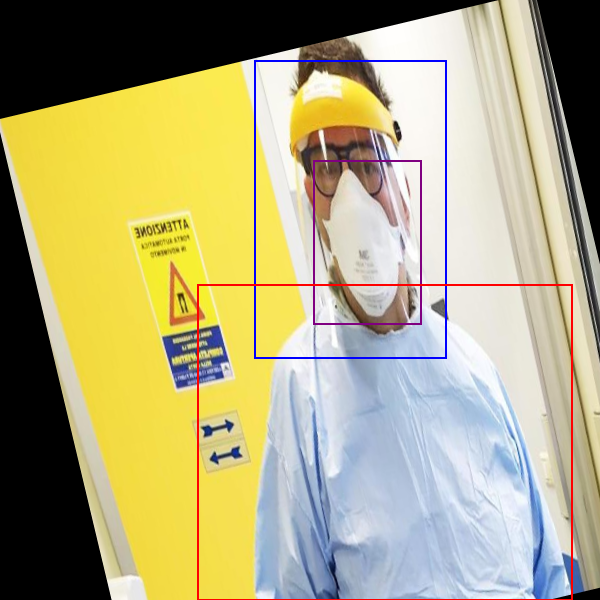

In [48]:
from PIL import ImageDraw

sample = dataset[39][1]
image = sample['augmented_image'].copy()
draw = ImageDraw.Draw(image)

boxes = sample['boxes']
labels = sample['labels']

# Define some colors. You can customize these.
colors = ["red", "blue", "green", "yellow", "purple", "orange"]

for i in range(boxes.size(0)):
    # Convert the box to a list of numbers.
    x, y, w, h = boxes[i].tolist()
    # Compute bottom-right coordinates.
    x2, y2 = x + w, y + h

    # Choose a color based on label (or you can define a mapping from label to color).
    label = int(labels[i].item())
    color = colors[label % len(colors)]

    # Draw the rectangle.
    draw.rectangle([x, y, x2, y2], outline=color, width=2)

image